In [60]:
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
cos = nn.CosineSimilarity(dim=0, eps=1e-9)
from torchvision import transforms
from models import ConvNet, resnet8, MLP
from utils import *
from torch.utils.data import DataLoader
device = "cuda"

In [61]:
alpha_d = 1.0
local_ep = 5
points = 50

In [62]:
# Define transformation (convert images to tensors and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image with mean and std
])

# Load the training dataset
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Load the test dataset
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for batch processing
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
client_loaders, test_loader, client_data_subsets = data.get_loaders(train_data, test_data, n_clients=100,
                                                                        alpha=alpha_d, batch_size=32, n_data=None, num_workers=4, seed=4)

Data split:
 - Client 0: [226  18  19  79  27 116  25   3  35  47]               -> sum=595
 - Client 1: [ 86  54   6  41   2  98 160 128   4  20]               -> sum=599
 - Client 2: [150  21  89  25   3  55  60 178   2  19]               -> sum=602
 - Client 3: [ 59 103  22 131 163   9  28  29   2  53]               -> sum=599
 - Client 4: [ 61 185  28  97  35  54  23   9   2 106]               -> sum=600
 - Client 5: [ 17  64  24  20  10 229 121  28  24  63]               -> sum=600
 - Client 6: [232   5   9  30   7 123   7  20  93  75]               -> sum=601
 - Client 7: [  0  71  38  46  45  74   1  81 155  87]               -> sum=598
 - Client 8: [ 22  79  22   9  83 138  50  82  37  79]               -> sum=601
 - Client 9: [29 83 47 76 98 26 25 55 72 89]                         -> sum=600
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
 - Client 91: [ 18  44  49  84  21  49 141  47  83  62]               -> sum=598
 - Client 92: 

In [63]:
# setup the environment
client_loader = client_loaders[0]
model1 = ConvNet(im_size = (28,28), dataset = 'fmnist').to(device)
model2 = ConvNet(im_size = (28,28), dataset = 'fmnist').to(device)
model3 = ConvNet(im_size = (28,28), dataset = 'fmnist').to(device)

# model1 = resnet8(dataset = 'fmnist').to(device)
# model2 = resnet8(dataset = 'fmnist').to(device)
# model3 = resnet8(dataset = 'fmnist').to(device)

model0 = {k: v.clone().detach() for k, v in model1.state_dict().items()}
model2.load_state_dict(model1.state_dict())

optimizer1 = optim.SGD(model1.parameters(), lr=0.001)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001)

# train with benign and the malicious model

train_op(model1, client_loader, optimizer1, epochs=local_ep, print_train_loss=True)
train_op_tr_flip(model2, client_loader, optimizer2, epochs=local_ep, class_num=10, print_train_loss=True)

num feat 2048
num feat 2048
num feat 2048


[2.38, 2.15, 1.98, 1.85, 1.74, 1.66, 1.61, 1.57, 1.53, 1.5, 1.49, 1.45, 1.43, 1.4, 1.38, 1.35, 1.34, 1.32, 1.3, 1.29, 1.28, 1.26, 1.25, 1.23, 1.22, 1.21, 1.2, 1.19, 1.18, 1.17, 1.16, 1.15, 1.14, 1.13, 1.12, 1.11, 1.1, 1.1, 1.09, 1.08, 1.07, 1.07, 1.06, 1.05, 1.04, 1.04, 1.03, 1.02, 1.02, 1.01]
[2.39, 2.18, 1.96, 1.75, 1.74, 1.73, 1.46, 1.49, 1.44, 1.62, 1.29, 1.5, 1.26, 1.32, 1.24, 1.19, 1.3, 1.15, 1.19, 1.22, 1.09, 0.95, 1.06, 1.13, 1.22, 1.3, 1.14, 1.1, 1.09, 0.97, 1.18, 1.22, 1.04, 1.35, 0.97, 0.98, 0.75, 1.29, 1.01, 1.02, 0.99, 1.03, 0.88, 1.03, 0.85, 0.99, 0.91, 0.87, 0.88, 0.8]


{'loss': 1.239242921857273}

In [64]:
def model_eval(model, test_loader):
    acc = eval_op_ensemble([model], test_loader)
    asr = eval_op_ensemble_tr_lf_attack([model], test_loader)
    return list(acc.values())[0], list(asr.values())[0]

def restore_dict_w(flat_grad, model_dict):
    restored_grad = {}
    start = 0
    for name, param in model_dict.items():
        num_elements = param.numel()
        restored_grad[name] = flat_grad[start:start + num_elements].view(param.shape)                          
        start += num_elements
    return restored_grad

def weighted_avg(a, b, alpha):
    return alpha * a + (1-alpha) *b

def plot_line(x, y, title='Line Plot', xlabel='X-axis', ylabel='Y-axis'):
    """
    Plots a line graph given x and y values.
    
    Parameters:
    x (list or array): X-axis values.
    y (list or array): Y-axis values.
    title (str): Title of the plot.
    xlabel (str): Label for the X-axis.
    ylabel (str): Label for the Y-axis.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, marker='o', linestyle='-', color='b', label='Line')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def replace_topk_budget_cos(a: torch.Tensor, b: torch.Tensor, delta: torch.Tensor, server:torch.Tensor, budget: float):
    """
    Replaces elements in `a` with corresponding elements from `b` based on the top-k values in `delta`,
    ensuring that the cosine similarity between the modified `a` (denoted as `c`) and the original `a`
    satisfies (1 - cos(a, c)) <= budget.

    Args:
        a (torch.Tensor): Original tensor.
        b (torch.Tensor): Replacement tensor.
        delta (torch.Tensor): Difference tensor used for ranking replacements.
        budget (float): Maximum allowable cosine distance between `a` and the modified tensor `c`.

    Returns:
        torch.Tensor: Modified tensor `c` with selected replacements.
    """
    flat_delta = delta.view(-1)
    flat_a = a.view(-1)
    flat_b = b.view(-1)
    flat_s = server.view(-1)
    
    # Sort indices by delta in descending order (top-k replacement candidates)
    sorted_indices = torch.argsort(flat_delta, descending=True)
    
    c = flat_a.clone()
    best_c = c.clone()
    best_cos_dist = 1 - torch.nn.functional.cosine_similarity((flat_a-flat_s).view(1, -1), 
                                                              (best_c-flat_s).view(1, -1)).item()
    # print(f"initial cos {best_cos_dist}")
    left, right = 0, len(sorted_indices)
    
    while left < right:
        
        mid = (left + right) // 2 
        c[:] = flat_a  # Reset c to original a before each iteration
        c[sorted_indices[:mid]] = flat_b[sorted_indices[:mid]]
        
        cos_sim = torch.nn.functional.cosine_similarity((flat_a-flat_s).view(1, -1), 
                                                        (c-flat_s).view(1, -1)).item()
        cos_dist = 1 - cos_sim
        print(f"left: {left}, right: {right}, mid: {mid}")
        if cos_dist <= budget:
            best_c = c.clone()
            best_cos_dist = cos_dist
            left = mid + 1
        else:
            right = mid 
    
    return best_c.view(a.shape), mid/len(sorted_indices)*100, best_cos_dist

In [65]:
flat_model0 = flat_dict(model0)
flat_model1 = flat_dict(model1.state_dict())
flat_model2 = flat_dict(model2.state_dict())
# find the reference for TopK
delta = torch.abs(flat_model1 - flat_model2)
delta = torch.abs(torch.mul((flat_model1 - flat_model2), flat_model2))
org_cos = cos((flat_model1 - flat_model0), (flat_model2 - flat_model0))

In [66]:
results1 = []
results2 = []
alphas1 = np.linspace(start=0, stop=1-org_cos.item(), num=points)
alphas2 = np.linspace(start=0, stop=1, num=points)

for alpha in alphas2:
    model3_w = weighted_avg(flat_model1, flat_model2, alpha)
    restored_crafted = restore_dict_w(model3_w,  model3.state_dict())
    model3.load_state_dict(restored_crafted)
    
    cos_sim = torch.nn.functional.cosine_similarity((flat_model1-flat_model0).view(1, -1), 
                                                (model3_w-flat_model0).view(1, -1)).item()
    
    # evaluate the model3's performance on main task and attack
    acc, asr = model_eval(model3, test_loader)
    results2.append([alpha, acc, asr, 1-cos_sim])
    # print(f"alpha:{alpha}, acc:{acc}, asr:{asr}, cos:{1-cos_sim}")

In [67]:
for alpha in alphas1:
    # craft the new model grad
    model3_w, k, cos_dist = replace_topk_budget_cos(flat_model1, flat_model2, delta, flat_model0, alpha)
    
    restored_crafted = restore_dict_w(model3_w,  model3.state_dict())
    # restore model weights to model
    model3.load_state_dict(restored_crafted)
    
    # evaluate the model3's performance on main task and attack
    acc, asr = model_eval(model3, test_loader)
    results1.append([alpha, acc, asr, cos_dist])

left: 0, right: 317706, mid: 158853
left: 0, right: 158853, mid: 79426
left: 0, right: 79426, mid: 39713
left: 0, right: 39713, mid: 19856
left: 0, right: 19856, mid: 9928
left: 0, right: 9928, mid: 4964
left: 0, right: 4964, mid: 2482
left: 0, right: 2482, mid: 1241
left: 0, right: 1241, mid: 620
left: 0, right: 620, mid: 310
left: 0, right: 310, mid: 155
left: 0, right: 155, mid: 77
left: 0, right: 77, mid: 38
left: 0, right: 38, mid: 19
left: 0, right: 19, mid: 9
left: 0, right: 9, mid: 4
left: 0, right: 4, mid: 2
left: 0, right: 2, mid: 1
left: 0, right: 1, mid: 0
left: 0, right: 317706, mid: 158853
left: 0, right: 158853, mid: 79426
left: 0, right: 79426, mid: 39713
left: 0, right: 39713, mid: 19856
left: 0, right: 19856, mid: 9928
left: 0, right: 9928, mid: 4964
left: 0, right: 4964, mid: 2482
left: 0, right: 2482, mid: 1241
left: 0, right: 1241, mid: 620
left: 0, right: 620, mid: 310
left: 0, right: 310, mid: 155
left: 156, right: 310, mid: 233
left: 156, right: 233, mid: 194
le

In [68]:
results1 = np.array(results1)
results2 = np.array(results2)

## ASR

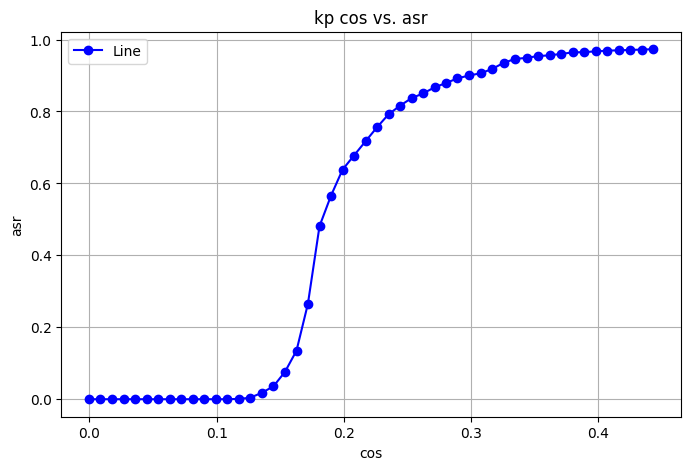

In [69]:
plot_line(results1[:,3], results1[:,2], title='kp cos vs. asr', xlabel='cos', ylabel='asr')

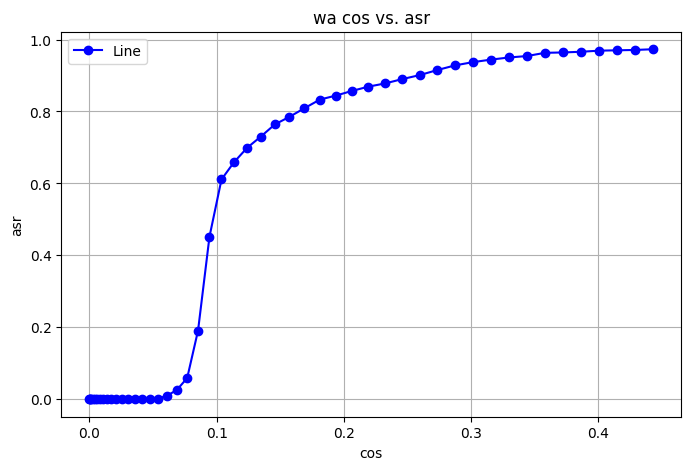

In [70]:
plot_line(results2[:,3], results2[:,2], title='wa cos vs. asr', xlabel='cos', ylabel='asr')

## ACC

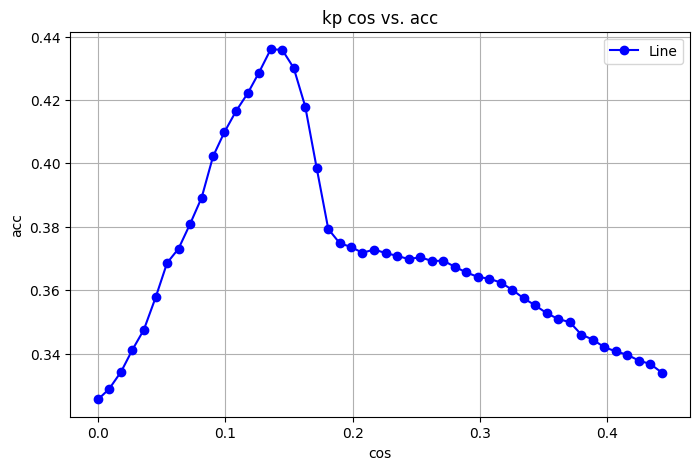

In [71]:
plot_line(results1[:,3], results1[:,1], title='kp cos vs. acc', xlabel='cos', ylabel='acc')

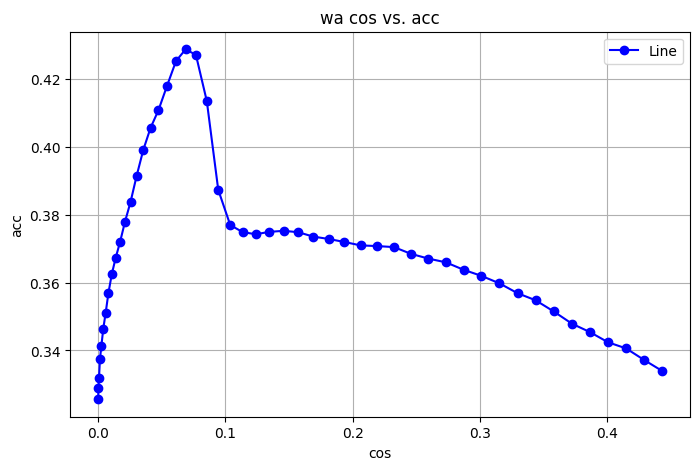

In [72]:
plot_line(results2[:,3], results2[:,1], title='wa cos vs. acc', xlabel='cos', ylabel='acc')

In [73]:
torch.tensor([1,2,3,4]) * torch.tensor([5,5,5,5])

tensor([ 5, 10, 15, 20])

In [74]:
def weighted_average_tensor(a: torch.Tensor, b: torch.Tensor, budget: float):
    """
    Compute tensor c as a weighted average of a and b such that:
        c = t * a + (1 - t) * b
    where t is in [0,1] and ensures that 1 - cos(a, c) <= budget.

    Uses binary search to find the optimal t.

    :param a: Tensor
    :param b: Tensor
    :param budget: Float, constraint on 1 - cosine similarity
    :return: Tuple (c, t)
    """
    
    def cosine_similarity(x, y):
        return torch.nn.functional.cosine_similarity(x.flatten(), y.flatten(), dim=0)
    
    left, right = 0.0, 1.0
    best_t = right
    while right - left > 1e-6:
        print(left, right)
        mid = (left + right) / 2
        c = mid * a + (1 - mid) * b
        cos_sim = cosine_similarity(a, c)
        print("cos", cos_sim)
        if 1 - cos_sim <= budget:
            best_t = mid  # Store valid t
            right = mid  # Try a smaller t
        else:
            left = mid  # Increase t
    
    c = best_t * a + (1 - best_t) * b
    return c, best_t


In [75]:
import torch

# Define example tensors
a = torch.tensor([1.0, 2.0, 3.0])
b = torch.tensor([4.0, 5.0, 6.0])
budget = 0.002  # Example budget

# Call the function
c, t = weighted_average_tensor(a, b, budget)

# Print results
print("t:", t)
print("c:", c)
print("Cosine Similarity:", torch.nn.functional.cosine_similarity(a.flatten(), c.flatten(), dim=0).item())
print("1 - Cosine Similarity:", 1 - torch.nn.functional.cosine_similarity(a.flatten(), c.flatten(), dim=0).item())


0.0 1.0
cos tensor(0.9875)
0.5 1.0
cos tensor(0.9951)
0.75 1.0
cos tensor(0.9984)
0.75 0.875
cos tensor(0.9969)
0.8125 0.875
cos tensor(0.9977)
0.84375 0.875
cos tensor(0.9981)
0.84375 0.859375
cos tensor(0.9979)
0.8515625 0.859375
cos tensor(0.9980)
0.85546875 0.859375
cos tensor(0.9980)
0.85546875 0.857421875
cos tensor(0.9980)
0.8564453125 0.857421875
cos tensor(0.9980)
0.85693359375 0.857421875
cos tensor(0.9980)
0.85693359375 0.857177734375
cos tensor(0.9980)
0.8570556640625 0.857177734375
cos tensor(0.9980)
0.85711669921875 0.857177734375
cos tensor(0.9980)
0.857147216796875 0.857177734375
cos tensor(0.9980)
0.8571624755859375 0.857177734375
cos tensor(0.9980)
0.8571624755859375 0.8571701049804688
cos tensor(0.9980)
0.8571624755859375 0.8571662902832031
cos tensor(0.9980)
0.8571624755859375 0.8571643829345703
cos tensor(0.9980)
t: 0.8571643829345703
c: tensor([1.4285, 2.4285, 3.4285])
Cosine Similarity: 0.9980000257492065
1 - Cosine Similarity: 0.001999974250793457


In [76]:
torch.nn.functional.cosine_similarity(a.flatten(), b.flatten(), dim=0).item()

0.9746317863464355

# Analyzing the Cos similiarity par layer

In [77]:
org_cos = cos((flat_model1 - flat_model0), (flat_model2 - flat_model0))

In [78]:
org_cos

tensor(0.5569, device='cuda:0')

In [79]:
layer_cos = dict()
lay_size = dict()
for name, value in model0.items():
    print(name)
    l_cos = 1- cos(torch.flatten((model1.state_dict()[name] - value)), 
                torch.flatten((model2.state_dict()[name] - value))).item()
    lay_size[name] = value.numel()
    layer_cos[name] = l_cos

features.0.weight
features.0.bias
features.1.weight
features.1.bias
features.4.weight
features.4.bias
features.5.weight
features.5.bias
features.8.weight
features.8.bias
features.9.weight
features.9.bias
classifier.weight
classifier.bias


In [80]:
layer_cos

{'features.0.weight': 0.3716301918029785,
 'features.0.bias': 1.0,
 'features.1.weight': 0.4292564392089844,
 'features.1.bias': 0.3886222839355469,
 'features.4.weight': 0.3934919834136963,
 'features.4.bias': 1.0,
 'features.5.weight': 0.38413041830062866,
 'features.5.bias': 0.3807019591331482,
 'features.8.weight': 0.40617966651916504,
 'features.8.bias': 1.0,
 'features.9.weight': 0.16362625360488892,
 'features.9.bias': 0.282295823097229,
 'classifier.weight': 0.4807339906692505,
 'classifier.bias': 0.7825815677642822}

In [81]:
lay_size

{'features.0.weight': 1152,
 'features.0.bias': 128,
 'features.1.weight': 128,
 'features.1.bias': 128,
 'features.4.weight': 147456,
 'features.4.bias': 128,
 'features.5.weight': 128,
 'features.5.bias': 128,
 'features.8.weight': 147456,
 'features.8.bias': 128,
 'features.9.weight': 128,
 'features.9.bias': 128,
 'classifier.weight': 20480,
 'classifier.bias': 10}

In [82]:
data = layer_cos
# data = lay_size

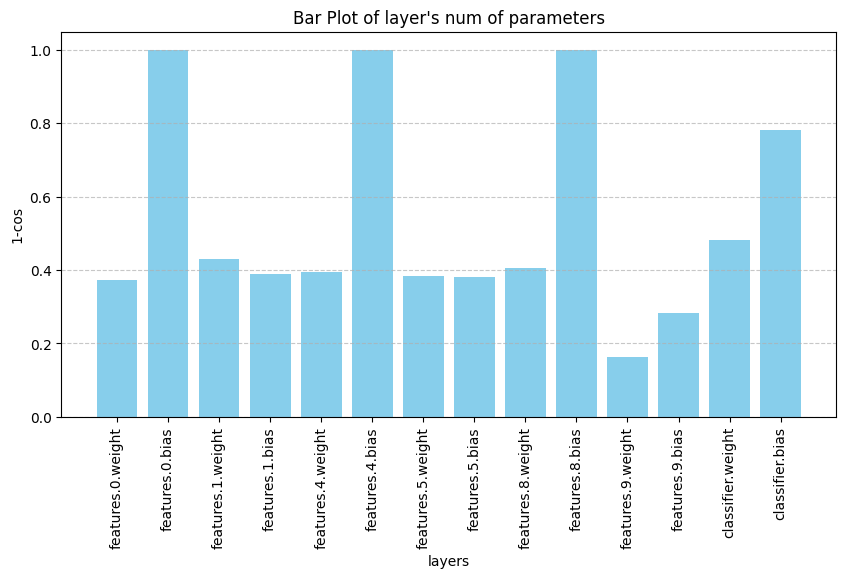

In [83]:
# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(keys, values, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("layers")
plt.ylabel("1-cos")
plt.title("Bar Plot of layer's num of parameters")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


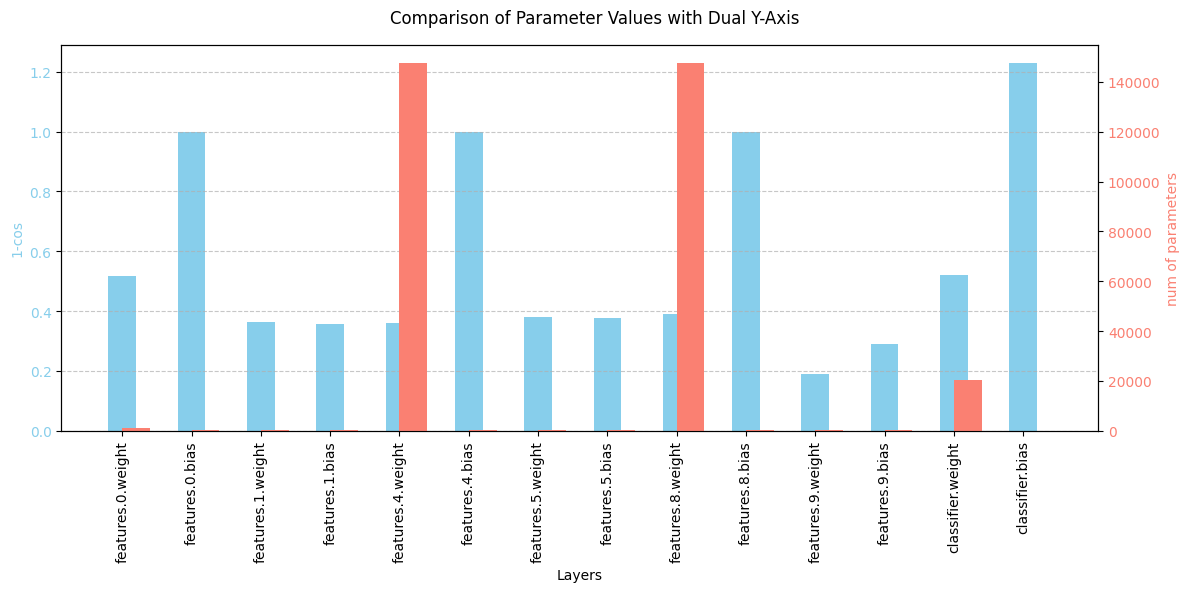

In [84]:
import matplotlib.pyplot as plt

# Data
data1 = {
    'features.0.weight': 0.5177639126777649,
    'features.0.bias': 1.0,
    'features.1.weight': 0.3622152805328369,
    'features.1.bias': 0.3554072380065918,
    'features.4.weight': 0.35985320806503296,
    'features.4.bias': 0.9998411813285202,
    'features.5.weight': 0.38094186782836914,
    'features.5.bias': 0.37840867042541504,
    'features.8.weight': 0.3893962502479553,
    'features.8.bias': 0.9999470604416274,
    'features.9.weight': 0.18956470489501953,
    'features.9.bias': 0.28989410400390625,
    'classifier.weight': 0.521280437707901,
    'classifier.bias': 1.2279798090457916
}

data2 = {
    'features.0.weight': 1152,
    'features.0.bias': 128,
    'features.1.weight': 128,
    'features.1.bias': 128,
    'features.4.weight': 147456,
    'features.4.bias': 128,
    'features.5.weight': 128,
    'features.5.bias': 128,
    'features.8.weight': 147456,
    'features.8.bias': 128,
    'features.9.weight': 128,
    'features.9.bias': 128,
    'classifier.weight': 20480,
    'classifier.bias': 10
}

# Extract keys and values
keys = list(data1.keys())
values1 = list(data1.values())
values2 = list(data2.values())

# Plot bar chart with dual y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

x = range(len(keys))
ax1.bar(x, values1, width=0.4, label='Dataset 1', color='skyblue', align='center')
ax1.set_xlabel("Layers")
ax1.set_ylabel("1-cos", color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticks(ticks=x)
ax1.set_xticklabels(keys, rotation=90)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Create a second y-axis
ax2 = ax1.twinx()
ax2.bar(x, values2, width=0.4, label='Dataset 2', color='salmon', align='edge')
ax2.set_ylabel("num of parameters", color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

fig.suptitle("Comparison of Parameter Values with Dual Y-Axis")
fig.tight_layout()
plt.show()

In [85]:
import torch
import random

def freeze_random_parameters(model, freeze_ratio=0.5):
    """
    Freezes a random fraction of model parameters.
    
    Args:
        model (torch.nn.Module): The model whose parameters should be frozen.
        freeze_ratio (float): The fraction of parameters to freeze (e.g., 0.5 for 50%).
    """
    # Get all parameter tensors
    param_list = list(model.parameters())

    # Determine the number of parameters to freeze
    num_to_freeze = int(len(param_list) * freeze_ratio)

    # Randomly select parameters to freeze
    params_to_freeze = random.sample(param_list, num_to_freeze)

    # Freeze selected parameters
    for param in params_to_freeze:
        param.requires_grad = False

# Example usage with a simple model
model = torch.nn.Sequential(
    torch.nn.Linear(10, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 5)
)

freeze_random_parameters(model, freeze_ratio=0.5)

# Check which parameters are frozen
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")


0.weight: requires_grad=False
0.bias: requires_grad=True
2.weight: requires_grad=True
2.bias: requires_grad=False
